In [3]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision

from torch.utils.data import DataLoader,Dataset

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

## Prepare the Datasets

### Create a CSV map of the Sipakmed images

In [4]:
def sipakmed_prep():
    root = "./CervicalCancer/Sipakmed/"

    all_img = []
    for path, subdirs, files in os.walk(root):
        for name in files:
            curr_img = os.path.join(path,name)
            all_img.append(curr_img)

    sipakmed_df = pd.DataFrame()
    sipakmed_df['LocalPath'] = all_img
    sipakmed_df['ID'] = sipakmed_df['LocalPath'].apply(lambda x: str(x.split("\\")[-1]))
    sipakmed_df['Slide'] = sipakmed_df['LocalPath'].apply(lambda x: 'False' if (str(x.split("\\")[1])) == 'CROPPED' else 'True')
    sipakmed_df['Specific_Status'] = sipakmed_df['LocalPath'].apply(lambda x: str((x.split("im_")[1]).split("\\")[0]))
    sipakmed_df['Status'] = sipakmed_df['Specific_Status'].apply(lambda x: 'Benign' if x == 'Metaplastic' else
    ('Normal' if x == 'Superficial-Intermediate' or x == 'Parabasal' else 'Abnormal'))

    sp_class = {'Metaplastic':4, 'Superficial-Intermediate':0, 'Parabasal':1, 'Koilocytotic':2, 'Dyskeratotic':3}
    sipakmed_df['Specific_Class'] = sipakmed_df['Specific_Status'].map(sp_class)
    gen_class = {'Benign':0, 'Normal':1, 'Abnormal':2}
    sipakmed_df['Class'] = sipakmed_df['Status'].map(gen_class)

    sipakmed_df = sipakmed_df.loc[sipakmed_df['ID'].str.contains('bmp')].reset_index(drop=True)
    
    #Uploads the created file for future use. Recommended to not use.
    #sipakmed_df.to_csv(root + '/results.csv')
    return sipakmed_df

### Prepare the Herlev Dataset to work with the Sipakmed one

In [5]:
def herlev_prep():
    root = './CervicalCancer/Herlev/smear2005/results.csv'
    img_folder = './CervicalCancer/Herlev/smear2005/Images/'

    herlev_df=pd.read_csv(root)
    herlev_df = herlev_df.rename(columns={'Class':'Specific_Class'})

    gen_class = {1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:2}
    herlev_df['Class'] = herlev_df['Specific_Class'].map(gen_class)
    herlev_df['LocalPath'] = herlev_df['ID'].apply(lambda x: str(img_folder + x))
    return herlev_df

### Now both datasets have classes: 0 (Benign), 1 (Normal), and 2 (Abnormal)

## Create the Custom Image Dataset Class for Pytorch

In [6]:
class DatasetSample(Dataset):
    def __init__(self, df, transform):
        # Initialization
        self.transform = transform
        
        self.image_names = df['LocalPath']
        self.img_class = np.array(df['Class'])

    def __len__(self):
        # Denotes the total number of samples
        return len(self.image_names)
    
    def __getitem__(self, index):
        # Retrieves the data
        image=cv2.imread(self.image_names.iloc[index])
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

        image = self.transform(image)
        label = self.img_class[index]

        x, y = image, label
        
        # Enable to output as single variable instead
        #sample = {'image': image,'labels':label}

        return x, y

## Function to prepare the dataset

In [7]:
def concat_data():
    # Load the dataframes
    sipakmed_df = sipakmed_prep()
    herlev_df = herlev_prep()

    # Final adjustments to make sure they're attributes match
    sipakmed_df = sipakmed_df.loc[sipakmed_df['Slide'] == 'False']
    herlev_df = herlev_df.loc[:,['LocalPath', 'Class']]
    sipakmed_df = sipakmed_df.loc[:,['LocalPath', 'Class']]
    
    concat_df = pd.concat([sipakmed_df,herlev_df], ignore_index=True)
    
    # Split them into training and testing sets
    train_set,test_set = train_test_split(concat_df,test_size=0.15)
    
    # Set it up to alter random training images for better results
    train_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((32, 32)),
                    transforms.RandomHorizontalFlip(p=0.75),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor()])

    test_transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize((32, 32)),
                    transforms.ToTensor()])

    train_dataset = DatasetSample(train_set, train_transform)
    test_dataset = DatasetSample(test_set, test_transform)

    Dtr = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True
    )
    
    Dte = DataLoader(
        test_dataset, 
        batch_size=4,
        shuffle=True
    )

    return(Dtr, Dte)

### Function to show a single batch of results

In [8]:
def imshow(images, labels, predicted_labels=None):
    
    # Using torchvision to make a grid of the images
    img = torchvision.utils.make_grid(images)

    # Inverting the normalization
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)

    # Plotting the grid
    fig, ax = plt.subplots(figsize=(6, 24))
    plt.imshow(img)

    if predicted_labels is not None:
        # Outputing the predicted labels
        ax.set_xlabel('Predicted labels', fontsize=18, labelpad=12)
        ax.set_xticks(torch.arange(len(images)) * 35 + 20)
        ax.set_xticklabels([classes[predicted_labels[j]] 
                            for j in range(len(images))], fontsize=12, rotation=30)
    
    # Outputing the True labels
    gax = ax.secondary_xaxis('top')
    gax.set_xlabel('True Labels', fontsize=18, labelpad=12)
    gax.set_xticks(torch.arange(len(images)) * 35 + 20)
    gax.set_xticklabels([classes[labels[j]] 
                         for j in range(len(images))], fontsize=12, rotation=30)
    plt.show()

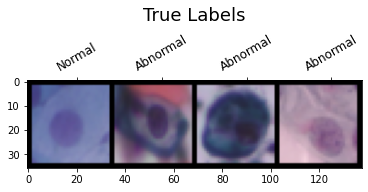

In [9]:
# Sets classes for the imshow function
classes = ('Benign', 'Normal', 'Abnormal')
Dtr, Dte = concat_data()

# Retrieves a batch of samples
images, labels = next(iter(Dte))
imshow(images, labels)